<h1 id='logo'><img src='https://raw.githubusercontent.com/Camilorb07/Integrador_S1_2021/main/Imagenes/Logo_EAFIT.png' width='350'  /></h1>

<hr style='border:2px solid #004B85'> </hr>


## Modelo predicitivo de desgaste (intención de renuncia) de empleados de la compañia IBM (Scope: Clasificación)

<hr style='border:2px solid #004B85'> </hr>

# Machine Learning Aplicado
## Semestre 2025-2

- #### Andrea Paola Alzate Ramirez
- #### Gustavo Adolfo Jerez Tous

<hr style='border:2px solid #004B85'> </hr>


- Este notebook fue desarrollado en Google Colab.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import warnings
warnings.filterwarnings('ignore')

<hr style='border:10px solid #004B85'> </hr>
<div align='center'>
  <font size ='20' style='color:red'><b>ENTREGA 2: COMPARACIÓN DE FAMILIAS</b>
</div>

<hr style='border:10px solid #004B85'> </hr>

Para esta entrega, se parte de los resultados del EDA y baseline realizados anteriormente, para proceder a la ingeniería de características y tuneo y validación de modelos.

# **PREPARACIÓN DEL ENTRENAMIENTO**

In [2]:
!pip install category_encoders -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from category_encoders.target_encoder import TargetEncoder

### Cargar el dataset final depurado de outliers

In [4]:
data_sin_outliers = pd.read_csv('dataset_ibm_sin_outliers.csv', index_col=None)
data_sin_outliers.head()

,index,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,outlier
0,0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,...,80,0,8,0,1,6,4,0,5,False
1,1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,...,80,1,10,3,3,10,7,1,7,False
2,2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,...,80,0,7,3,3,0,0,0,0,False
3,3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,...,80,0,8,3,3,8,7,3,0,False
4,4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,...,80,1,6,3,3,2,2,2,2,False


In [5]:
data_sin_outliers['Attrition'].value_counts()

,count
Attrition,
No,1106
Yes,217


### Definir variables independientes y codificar el target a tipo numérico

In [6]:
feat_target = 'Attrition'
feats_total = list(data_sin_outliers.columns)
feats_drop = [feat_target, 'index', 'outlier', 'EmployeeNumber', 'EmployeeCount', 'StandardHours', 'DailyRate', 'MonthlyRate', 'Over18', 'HourlyRate']
feats_train = [item for item in feats_total if item not in feats_drop]
feats_train

['Age',
 'BusinessTravel',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EnvironmentSatisfaction',
 'Gender',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'OverTime',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [7]:
data_sin_outliers = data_sin_outliers[feats_train + [feat_target]]
data_sin_outliers[feat_target] = data_sin_outliers[feat_target].map({'Yes': 1, 'No': 0})

numeric_cols = data_sin_outliers.select_dtypes(include=[np.number]).columns
print('Variables numéricas:\n', list(numeric_cols))
categorical_cols = data_sin_outliers.select_dtypes(include=['object']).columns
print('\nVariables categóricas:\n', list(categorical_cols))

Variables numéricas:
 ['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition']

Variables categóricas:
 ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']


In [8]:
data_sin_outliers['Attrition'].value_counts()

,count
Attrition,
0,1106
1,217


# **INGENIERÍA DE CARACTERÍSTICAS**

Si bien se obtuvieron buenos resultados de clasificación a partir del modelo baseline, se identificaron oportunidades de mejora principalmente en la preparación de los datos resumidas en dos puntos claves:

1. Crear nuevas características basadas en conocimiento del dominio para robustecer el entrenamiento
2. Aplicar mejores transformaciones a las variables categóricas, ya que aunque se trató inicialmente mediante target encoding, se evidenció que esto no es tan conveniente aplicarlo a todas las variables pues se puede incurrir en sobreajuste o leakage en categorías con pocos registros y desbalance de clases respecto a la variable de respuesta. Se decide entonces aplicar codificación categórica así:

* **Variables ordinales:** aquellas que ya tienen un orden implícito como *JobSatisfaction* -> Ordinal Encoding
* **Variables no ordinales de baja cardinalidad:** aquellas que no tienen orden pero si pocas dimensiones como *MaritalStatus* -> OneHot Encoding
* **Variables no ordinales de alta cardinalidad:** aquellas que no tienen orden pero si muchas dimensiones como *JobRole* -> Target Encoding

In [9]:
data_sin_outliers.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,41,Travel_Rarely,Sales,1,2,Life Sciences,2,Female,3,2,...,1,0,8,0,1,6,4,0,5,1
1,49,Travel_Frequently,Research & Development,8,1,Life Sciences,3,Male,2,2,...,4,1,10,3,3,10,7,1,7,0
2,37,Travel_Rarely,Research & Development,2,2,Other,4,Male,2,1,...,2,0,7,3,3,0,0,0,0,1
3,33,Travel_Frequently,Research & Development,3,4,Life Sciences,4,Female,3,1,...,3,0,8,3,3,8,7,3,0,0
4,27,Travel_Rarely,Research & Development,2,1,Medical,1,Male,3,1,...,4,1,6,3,3,2,2,2,2,0


In [10]:
data_sin_outliers['Attrition'].value_counts()

,count
Attrition,
0,1106
1,217


In [11]:
data_sin_outliers = data_sin_outliers[feats_train + [feat_target]]

numeric_cols = data_sin_outliers.select_dtypes(include=[np.number]).columns
print('Variables numéricas:\n', list(numeric_cols))
categorical_cols = data_sin_outliers.select_dtypes(include=['object']).columns
print('\nVariables categóricas:\n', list(categorical_cols))

Variables numéricas:
 ['Age', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition']

Variables categóricas:
 ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']


### Crear nuevas variables

Para robustecer la modelación, se agregan nuevas características al dataset, aplicando transformaciones sobre las ya existentes, de tal manera que se puedan incluir mejores representaciones del conjunto de datos y por lo tanto encontrar mejores patrones para que el modelo aprenda mejor.

Las características a incluir son:

**Relaciones**
- `Income_vs_JobLevel`: Ingreso mensual relativo al nivel del puesto. Capta si alguien gana menos/más que lo esperado para su posición.
- `Tenure_ratio`: Proporción de antigüedad en la empresa respecto a la experiencia. Distingue a alguien nuevo en la empresa vs empleados con carreras largas dentro.
- `Stability_with_manager`: Estabilidad con el actual jefe. Rrefleja continuidad en el liderazgo del empleado durante su estancia en la empresa.
- `Recent_promotion`: Indica (binario) si el empleado tuvo un ascenso recientemente (en el último año). Refleja el momemto de la carrera laboral de la persona.
- `OverTime_x_JobLevel`: Mide cómo cambia el riesgo cuando se acumula overtime en niveles de experiencia más altos: si el efecto del overtime no es igual para juniors y seniors, esta variable ayuda a capturarlo (por ejemplo, overtime en niveles altos podría asociarse a más presión/responsabilidades y mayor probabilidad de renuncia)

**Métricas de satisfacción**
- `Satisfaction_mean`: Promedio de las satisfacciones claves (Job/Environment/Relationship). Da una visión global del clima percibido en la empresa.
- `Satisfaction_min`: Mínimo entre esas satisfacciones. Captura la 'incomodidad' mas grande que puede disparar insatisfacción aun con buen promedio.


In [12]:
ordinal_cols = ['Education','JobSatisfaction','EnvironmentSatisfaction',
            'RelationshipSatisfaction','JobInvolvement','WorkLifeBalance',
            'PerformanceRating','StockOptionLevel', 'JobLevel']

nominal_cols = ['Department', 'BusinessTravel', 'MaritalStatus', 'EducationField', 'OverTime']
high_card_cols = ['JobRole']
numerical_cols = ['Age','MonthlyIncome', 'DistanceFromHome','PercentSalaryHike',  'NumCompaniesWorked',
            'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'TrainingTimesLastYear',
            'YearsWithCurrManager', 'TotalWorkingYears']

In [13]:
def add_custom_features(X):
  X = X.copy()
  # Relaciones
  X['Income_vs_JobLevel'] = X['MonthlyIncome'] / (X['JobLevel'] + 1)
  X['Tenure_ratio'] = X['YearsAtCompany'] / (X['TotalWorkingYears'] + 1)
  X['Stability_with_manager'] = X['YearsWithCurrManager'] / (X['YearsAtCompany'] + 1)
  X['Recent_promotion'] = (X['YearsSinceLastPromotion'] <= 1).astype(int)

  X['OverTime_bin'] = (X['OverTime'] == 'Yes').astype(int)
  X['OverTime_x_JobLevel'] = X['OverTime_bin'] * X['JobLevel']

  # Métricas de satisfacción
  sats = ['JobSatisfaction','EnvironmentSatisfaction','RelationshipSatisfaction']
  X['Satisfaction_mean'] = X[sats].mean(axis=1)
  X['Satisfaction_min']  = X[sats].min(axis=1)

  return X

custom_ft = FunctionTransformer(add_custom_features)

### Revisar relación de las nuevas características con el target

In [14]:
# columnas numéricas ampliadas luego del feature engineering
new_num_cols = ['Income_vs_JobLevel','Tenure_ratio','Stability_with_manager','Recent_promotion','Satisfaction_mean','Satisfaction_min']
numerical_cols_plus = numerical_cols + new_num_cols

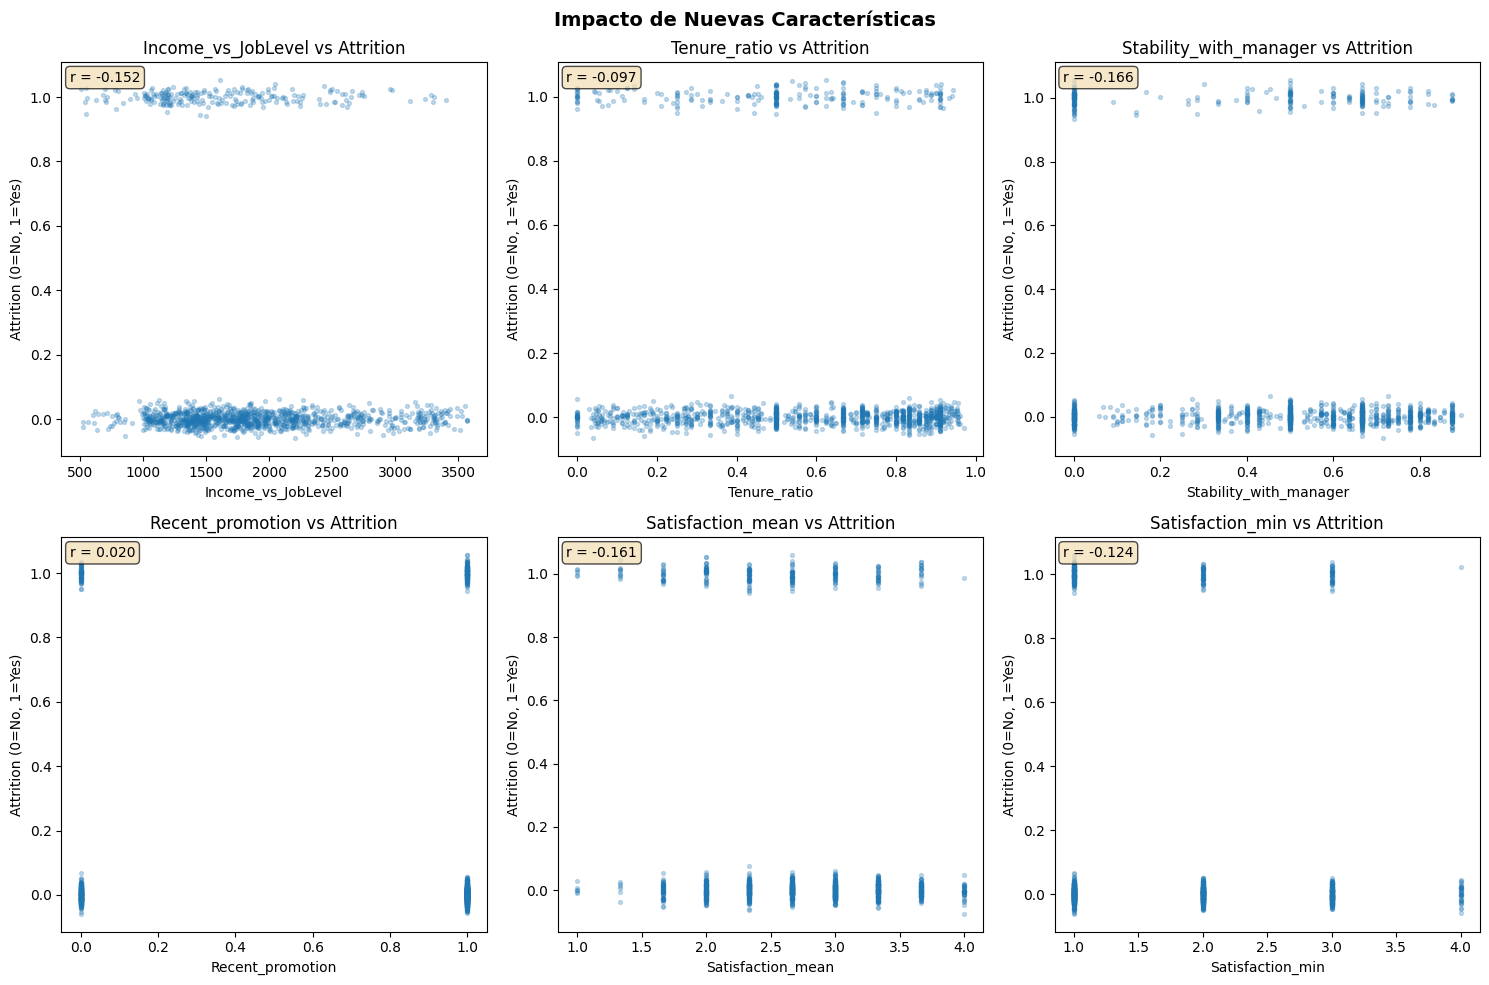

In [15]:
df = data_sin_outliers.copy()
df['Attrition_bin'] = df['Attrition'].astype(int)

new_features = add_custom_features(df)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, feature in enumerate(new_num_cols):
  ax = axes[idx // 3, idx % 3]

  y_jitter = new_features['Attrition_bin'] + np.random.normal(0, 0.02, size=len(new_features))

  # Graficar (scatter simple)
  ax.scatter(new_features[feature], y_jitter, alpha=0.25, s=8)
  ax.set_title(f'{feature} vs Attrition')
  ax.set_ylabel('Attrition (0=No, 1=Yes)')
  ax.set_xlabel(feature)

  # Correlación punto-biserial (equivale a Pearson entre continua y 0/1)
  corr = new_features[feature].corr(new_features['Attrition_bin'])
  ax.text(
      0.02, 0.95, f'r = {corr:.3f}',
      transform=ax.transAxes,
      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7)
  )

plt.suptitle('Impacto de Nuevas Características', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

En general se observa que las nuevas características capturan de forma moderada las dinámicas dentro de la empresa: los empleados que reciben una compensación más acorde a su nivel, mantienen relaciones estables con sus jefes y se sienten más satisfechos en general, tienden a permanecer por más tiempo. Aunque ninguna variable por sí sola explica fuertemente el target, combinadas aportan señales útiles que pueden mejorar los modelos predictivos a entrenar. Se muestra a continuación un resumen de las principales conclusiones:

| Característica             | Correlación (r) | Interpretación                                                                                                                                                                                                                                |
| -------------------------- | --------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Income_vs_JobLevel**     | −0.152          | Los empleados con **mayor ingreso relativo a su nivel de cargo** tienden a tener **menor renuncia**. La relación es débil pero negativa, lo que sugiere que una remuneración justa respecto al nivel contribuye moderadamente a la retención. |
| **Tenure_ratio**           | −0.097          | A mayor tiempo en la empresa **en proporción a su carrera**, menor probabilidad de salida. El efecto es leve pero consistente.                                                                                                                |
| **Stability_with_manager** | −0.166          | Una de las correlaciones negativas más fuertes. Mantenerse **más tiempo con el mismo jefe o gerente** tiende a **reducir la renuncia**, lo cual refleja que la estabilidad en la gestión favorece la permanencia.                             |
| **Recent_promotion**       | +0.020          | Correlación positiva muy débil, prácticamente nula. Haber sido **promovido recientemente** no parece influir directamente en la renuncia; puede haber efectos opuestos (algunos se quedan, otros buscan nuevos retos).                        |
| **Satisfaction_mean**      | −0.161          | A mayor satisfacción promedio (con el trabajo, el entorno o el jefe), **menor probabilidad de salida**. Coincide con la intuición: los empleados insatisfechos tienden a irse.                                                                |
| **Satisfaction_min**       | −0.124          | La **menor dimensión de satisfacción** también está negativamente asociada: si el empleado evalúa algún aspecto con una calificación muy baja, aumenta su riesgo de renuncia.                                                                 |


### Definición de transformaciones a aplicar en los pipelines

In [16]:
# Ordinal Encoding para las categorías que tienen orden implícito
ord_trf = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# One Hot Encoding para las categorías sin orden aparente y baja cardinalidad
onehot_trf = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=True)

# Target Encoding sobre categorías de alta cardinalidad
target_enc = TargetEncoder(cols=high_card_cols, smoothing=1.0)

# Estandarización sobre las variables numéricas
num_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Consolidar los tratamientos por columna
pre = ColumnTransformer(
    transformers=[
        ('ord', ord_trf, ordinal_cols),
        ('nom', onehot_trf, nominal_cols),
        ('high', 'passthrough', high_card_cols),  # se aplica dentro del pipeline final para evitar leakage
        ('num', num_pipe, numerical_cols_plus),
    ],
    remainder='drop'
)


### Pipeline base aplicando CV estratificada

In [17]:
pipe = Pipeline(steps=[
    ('feats', custom_ft),
    ('tenc', target_enc), # idealmente OOF en CV
    ('pre', pre),
    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=None))
])


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_validate(pipe, X=data_sin_outliers.drop(columns=['Gender', 'Attrition']),
                        y=data_sin_outliers['Attrition'],
                        cv=cv, scoring=['roc_auc','average_precision','f1', 'recall'], n_jobs=-1)

print({k: scores[k].mean() for k in scores if 'test' in k})

{'test_roc_auc': np.float64(0.8390162104936387), 'test_average_precision': np.float64(0.6231355968980796), 'test_f1': np.float64(0.5360633657154621), 'test_recall': np.float64(0.7695560253699789)}


# **PIPELINES DE ENTRENAMIENTO**

Este pipeline implementa un flujo completo de búsqueda de hiperparámetros, evaluación cruzada y análisis de desempeño para distintos clasificadores aplicados al dataset de IBM. Se parte de los resultados del torneo de modelos usado para ajustar un baseline y las transformaciones realizadas en las etapas previas de EDA y FE para configurar el mejor flujo de modelación, que cuenta con los siguientes conmponentes:

#### **Preprocesamiento flexible**
El pipeline admite componentes opcionales:

* custom_ft: transformaciones de ingeniería de características.
* target_enc: codificadores de variables categóricas supervisadas.
* pre: preprocesadores genéricos (escalado).

#### **Validación cruzada estratificada**
Usa StratifiedKFold para mantener la proporción de clases en cada fold, garantizando una comparación justa entre modelos.

#### **Métricas de evaluación múltiples**
Evalúa simultáneamente varias métricas (ROC AUC, precisión balanceada, F1, recall, precisión promedio).
El modelo se reentrena optimizando una métrica principal (refit_metric='roc_auc').

#### **Optimización de hiperparámetros**
Se opta por utilizar dos enfoques diferentes:
* GridSearchCV para modelos pequeños y rápidos (Regresión Logística).
* RandomizedSearchCV con n_iter controlado para modelos complejos (LGBM, XGB, KNN).
Cada búsqueda incluye control de tiempo de entrenamiento/iteración y registro de resultados.

Al final se consolidan los resultados de los mejores estimadores encontrados para cada tipo de modelo y facilitar su análisis

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# ------------------------------------------------------------------------
# Helpers
# ------------------------------------------------------------------------
def _elapsed(fit_callable):
    import time
    t0 = time.perf_counter()
    fit_callable()
    return time.perf_counter() - t0

def _safe_get(cvres, key, idx, default=np.nan):
    return cvres[key][idx] if key in cvres else default

def resume_search(name, search, elapsed=None):
    cv = search.cv_results_
    i = search.best_index_
    return {
        "model": name,
        "best_roc_auc": search.best_score_, # refit metric
        "best_pr_auc": _safe_get(cv, "mean_test_pr_auc", i),
        "best_f1": _safe_get(cv, "mean_test_f1", i),
        "best_recall": _safe_get(cv, "mean_test_recall", i),
        "best_balanced_accuracy": _safe_get(cv, "mean_test_balanced_accuracy", i),
        "mean_fit_time": _safe_get(cv, "mean_fit_time", i),
        "mean_score_time": _safe_get(cv, "mean_score_time", i),
        "elapsed_time": elapsed,
        "best_params": {k: (v.item() if hasattr(v, "item") else v)
                        for k, v in search.best_params_.items()}
    }

def _extract_per_fold_scores(search, metric='roc_auc'):
    i = search.best_index_
    cvres = search.cv_results_
    # Collect split-wise test
    split_test = []
    split_train = []

    tkey = f'split{{k}}_test_{metric}'
    trkey = f'split{{k}}_train_{metric}'

    k = 0
    while True:
        key = tkey.format(k=k)
        if key not in cvres:
            break
        split_test.append(cvres[key][i])
        # train might not be present if return_train_score=False
        key_tr = trkey.format(k=k)
        split_train.append(cvres[key_tr][i] if key_tr in cvres else np.nan)
        k += 1

    return np.array(split_test), np.array(split_train)

def plot_cv_behavior(search, model_name, metrics=('roc_auc','pr_auc')):
    nrows = len(metrics)
    fig, axes = plt.subplots(nrows, 2, figsize=(12, 4*nrows))
    if nrows == 1:
        axes = np.array([axes])  # shape (1,2)

    fig.suptitle(f'Comportamiento de CV — {model_name} (best params)', fontsize=14, fontweight='bold')

    for r, metric in enumerate(metrics):
        split_test, split_train = _extract_per_fold_scores(search, metric=metric)

        # Izquierda: Test scores para cada fold
        ax = axes[r, 0]
        ax.bar(np.arange(len(split_test)), split_test)
        ax.set_title(f'{metric.upper()} por fold (test)')
        ax.set_xlabel('Fold')
        ax.set_ylabel(metric.upper())
        ax.set_ylim(0, 1)
        for i, v in enumerate(split_test):
            ax.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=8)

        # Derecha: Mean train vs test (if we have train)
        ax2 = axes[r, 1]
        means = [np.nanmean(split_train), np.nanmean(split_test)]
        labels = ['Train', 'Test']
        ax2.bar(labels, means)
        ax2.set_title(f'{metric.upper()} mean (train vs test)')
        ax2.set_ylim(0, 1)
        for i, v in enumerate(means):
            if not np.isnan(v):
                ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------
# Función principal de tuneo y validación de entrenamiento
# ------------------------------------------------------------------------
def tuning_validation_model(
    X, y,
    custom_ft=None, target_enc=None, pre=None,
    models=('RL','LGBM','XGB','KNN'),
    cv=None,
    scoring=None,
    refit_metric='roc_auc',
    n_iters=60,
    random_state=42,
    plot=True,
    plot_metrics=('roc_auc','pr_auc'),
    return_train_score=True
):
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    if scoring is None:
        scoring = {'roc_auc': 'roc_auc', 'balanced_accuracy': 'precision', 'pr_auc': 'average_precision', 'recall': 'recall', 'f1': 'f1'}

    def make_pipe(est):
        steps = []
        if custom_ft is not None: steps.append(('feats', custom_ft))
        if target_enc is not None: steps.append(('tenc', target_enc))
        if pre is not None: steps.append(('pre', pre))
        steps.append(('clf', est))  # explicit name for param grid
        pipe = Pipeline(steps)
        pipe.set_output(transform='default')

        return pipe

    results = []
    best_estimators = {}

    # --- Regresión Logística ---
    if 'RL' in models:
        print('Aplicando tuning a Regresión Logística: GRID SEARCH')
        lr = LogisticRegression(max_iter=5000, class_weight='balanced')
        lr_pipe = make_pipe(lr)
        lr_grid = {
            'clf__penalty': ['l1', 'l2'],
            'clf__C': [0.001, 0.05, 0.25, 0.5, 1, 2, 3, 5],
            'clf__solver': ['lbfgs', 'liblinear', 'newton-cg'],
            'clf__max_iter': [1000, 3000, 5000]
        }

        lr_search = GridSearchCV(
            estimator=lr_pipe,
            param_grid=lr_grid,
            scoring=scoring,
            refit=refit_metric,
            cv=cv,
            n_jobs=-1,
            verbose=1,
            return_train_score=return_train_score  # para poder plotear el comportamiento en CV
        )
        elapsed = _elapsed(lambda: lr_search.fit(X, y))
        results.append(resume_search('LogisticRegression', lr_search, elapsed))
        best_estimators['RL'] = lr_search.best_estimator_
        if plot:
            plot_cv_behavior(lr_search, 'Regresión Logística', metrics=plot_metrics)

    # --- LightGBM ---
    if 'LGBM' in models:
        print('Aplicando tuning a LightGBM: RANDOM Search')
        lgbm = LGBMClassifier(objective='binary', class_weight='balanced',
                              random_state=random_state, n_jobs=-1, verbosity=-1)
        lgbm_pipe = make_pipe(lgbm)
        lgbm_dist = {
            'clf__n_estimators': np.arange(300, 901, 100),
            'clf__learning_rate': np.linspace(0.02, 0.12, 6),
            'clf__num_leaves': np.arange(15, 64, 4),
            'clf__max_depth': [3,4,5,6,7],
            'clf__min_child_samples': np.arange(10, 51, 5),
            'clf__subsample': np.linspace(0.6, 1.0, 9),
            'clf__colsample_bytree': np.linspace(0.6, 1.0, 9),
            'clf__reg_alpha': np.linspace(0.0, 1.0, 6),
            'clf__reg_lambda': np.linspace(0.0, 1.0, 6),
        }
        lgbm_search = RandomizedSearchCV(
            estimator=lgbm_pipe,
            param_distributions=lgbm_dist,
            n_iter=n_iters,
            scoring=scoring,
            refit=refit_metric,
            cv=cv,
            n_jobs=1, # para evitar doble paralelización inadeacuada, pues ya se definió en el objeto modelo
            verbose=0,
            random_state=random_state,
            return_train_score=return_train_score
        )
        elapsed = _elapsed(lambda: lgbm_search.fit(X, y))
        results.append(resume_search('LightGBM', lgbm_search, elapsed))
        best_estimators['LGBM'] = lgbm_search.best_estimator_
        if plot:
            plot_cv_behavior(lgbm_search, 'LightGBM', metrics=plot_metrics)

    # --- XGBoost ---
    if 'XGB' in models or 'XGBOOST' in models:
        print('Aplicando tuning a XGBoost: RANDOM Search')
        pos_w = y.value_counts()[0] / y.value_counts()[1]
        xgb = XGBClassifier(
            objective='binary:logistic',
            eval_metric='auc',
            tree_method='hist',
            n_jobs=-1,
            scale_pos_weight=pos_w,
            random_state=random_state
        )
        xgb_pipe = make_pipe(xgb)
        xgb_dist = {
            'clf__n_estimators': np.arange(300, 901, 100),
            'clf__learning_rate': np.linspace(0.02, 0.12, 6),
            'clf__max_depth': np.arange(3, 9),
            'clf__min_child_weight': np.arange(1, 7),
            'clf__subsample': np.linspace(0.6, 1.0, 9),
            'clf__colsample_bytree': np.linspace(0.6, 1.0, 9),
            'clf__gamma': np.linspace(0.0, 4.0, 9),
            'clf__reg_alpha': np.linspace(0.0, 1.0, 6),
            'clf__reg_lambda': np.linspace(0.0, 2.0, 9),
        }
        xgb_search = RandomizedSearchCV(
            estimator=xgb_pipe,
            param_distributions=xgb_dist,
            n_iter=n_iters,
            scoring=scoring,
            refit=refit_metric,
            cv=cv,
            n_jobs=1,
            verbose=1,
            random_state=random_state,
            return_train_score=return_train_score
        )
        elapsed = _elapsed(lambda: xgb_search.fit(X, y))
        results.append(resume_search('XGBoost', xgb_search, elapsed))
        best_estimators['XGB'] = xgb_search.best_estimator_
        if plot:
            plot_cv_behavior(xgb_search, 'XGBoost', metrics=plot_metrics)

    # --- KNN ---
    if 'KNN' in models:
        print('Aplicando tuning a KNN: RANDOM Search')
        knn = KNeighborsClassifier()
        knn_pipe = make_pipe(knn)
        knn_dist = {
            'clf__n_neighbors': np.arange(3, 51),
            'clf__weights': ['uniform', 'distance'],
            'clf__metric': ['euclidean', 'manhattan', 'minkowski'],
            'clf__p': [1, 2],  # para minkowski
        }
        knn_search = RandomizedSearchCV(
            estimator=knn_pipe,
            param_distributions=knn_dist,
            n_iter=min(n_iters, 50),
            scoring=scoring,
            refit=refit_metric,
            cv=cv,
            n_jobs=-1,
            verbose=1,
            random_state=random_state,
            return_train_score=return_train_score
        )
        elapsed = _elapsed(lambda: knn_search.fit(X, y))
        results.append(resume_search('KNN', knn_search, elapsed))
        best_estimators['KNN'] = knn_search.best_estimator_
        if plot:
            plot_cv_behavior(knn_search, 'KNN', metrics=plot_metrics)

    results_df = pd.DataFrame(results).sort_values('best_roc_auc', ascending=False).reset_index(drop=True)
    return results_df, best_estimators


## **Particionamiento de la base final de entrenamiento**

In [19]:
X = data_sin_outliers.drop(columns=['Gender', 'Attrition'])
y = data_sin_outliers['Attrition']

print(X.shape, y.shape)

(1323, 26) (1323,)


Se aplica estratificación sobre el target para representar adecuadamente el desbalance presente y se deja un 20% del conjunto de datos como conjunto de prueba para la evaluación final de modelos candidatos

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  stratify=y,
                                                  random_state=42)

print(f"\nConjuntos creados:")
print(f" • Entrenamiento: {len(X_train):,} muestras ({len(X_train)/len(df)*100:.1f}%)")
print(f" • Prueba: {len(X_test):,} muestras ({len(X_test)/len(df)*100:.1f}%)")


Conjuntos creados:
 • Entrenamiento: 1,058 muestras (80.0%)
 • Prueba: 265 muestras (20.0%)


In [24]:
y_train.value_counts(normalize=True)

,proportion
Attrition,
0,0.835539
1,0.164461


## **Configurar ejecución de pipelines**

De acuerdo con los resultados del torneo de modelos, y del baseline seleccionado, se decide entrenar clasificadores con buenas métricas de partida y que además sean adecuados para el tamaño del dataset y la complejidad del problema.

### **1. Familias de modelos**

##### **Regresión Logística (LR)**

Es un modelo lineal interpretable, ideal para problemas de clasificación binaria como Attrition (Sí/No). Permite analizar la influencia de cada variable en la probabilidad de rotación, aportando transparencia y explicabilidad. En la tabla, logra la mayor AUC (0.8571) y buen equilibrio entre Precisión (0.7098) y F1 (0.5186), lo que sugiere un desempeño robusto y estable.

##### **LightGBM (LGBMClassifier)**

Es un algoritmo basado en árboles con boosting, eficiente en datasets pequeños y medianos. Captura interacciones no lineales y efectos complejos entre variables (por ejemplo, satisfacción, antigüedad, nivel de ingreso). Tiene una alta Accuracy (0.8812) y buen AUC (0.8201), con tiempos de entrenamiento razonables.

##### **XGBoost (XGBClassifier)**

También usa boosting, pero optimiza el entrenamiento mediante regularización y control de sobreajuste. Suele tener gran rendimiento en datasets tabulares y desbalanceados. En el torneo base, presenta buen AUC (0.8015) y un equilibrio razonable entre precisión y recall, útil para capturar empleados en riesgo de salida.

##### **K-Nearest Neighbors (KNN)**

Modelo no paramétrico y de baja complejidad que sirve como contraste frente a modelos lineales y de boosting. Evalúa similitud entre empleados según múltiples variables, lo que puede ofrecer una visión basada en proximidad de perfiles con riesgo de rotación.
Aunque su AUC (0.7275) es menor, aporta diversidad de enfoque en la comparación y ayuda a validar la robustez del pipeline.

### **2. Cantidad de iteraciones**

Para el enfoque RandomSearch, se decide evaluar un máximo de **200 iteraciones** dado el tamaño reducido del dataset, y haciendo un tradeoff entre tiempo de ejecución y exhaustividad en la búsqueda.

### **3. Tipo de CV**
Se decide utilizar CV Estratificada ya que esta configuración garantiza una validación cruzada balanceada, reproducible y representativa del problema de rotación. Se consideran **5 splits** pues este valor ofrece un buen equilibrio entre estabilidad y costo computacional, y se mezcla aleatoriamente los datos antes de crear los folds, evitando sesgos por orden de los registros.

### **4. Métricas de scoring y refit**
Dado el problema de classificación, se escogen métricas que reflejen una buena separación de las clases como `roc_auc`, con el plus de enfocarse especificamente en la clase positiva mediante `average_precision`.
Otra métrica importante es el `balanced_accuracy` pues, a diferecnia de la precisión estandar, esta hace que el score sea más representativo del imbalance de clases presente, siendo más adecuada para el problema. Igualmente, el `f1` score como indicador de equilibrio entre precisión y recall.



#### **Experimento 1: split 60/20/20 y refit con pr_auc**

Aplicando tuning a Regresión Logística: GRID SEARCH
Fitting 5 folds for each of 144 candidates, totalling 720 fits


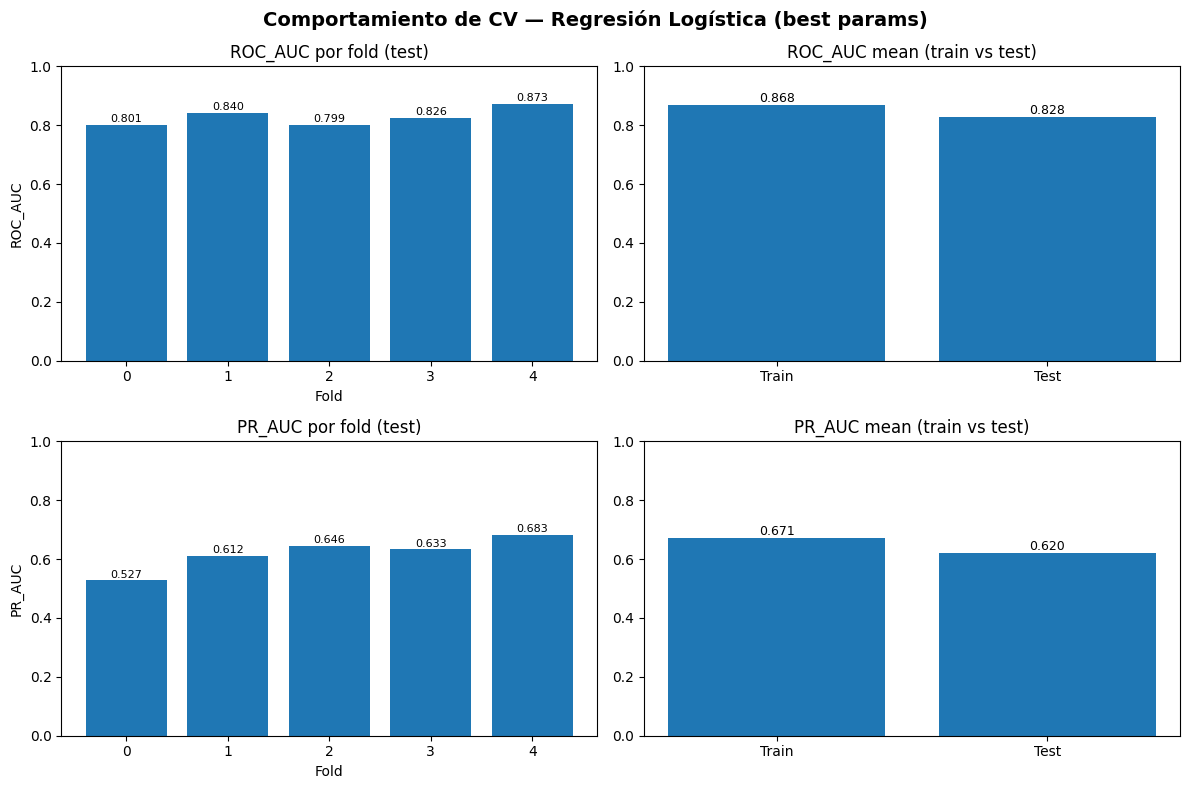

Aplicando tuning a LightGBM: RANDOM Search


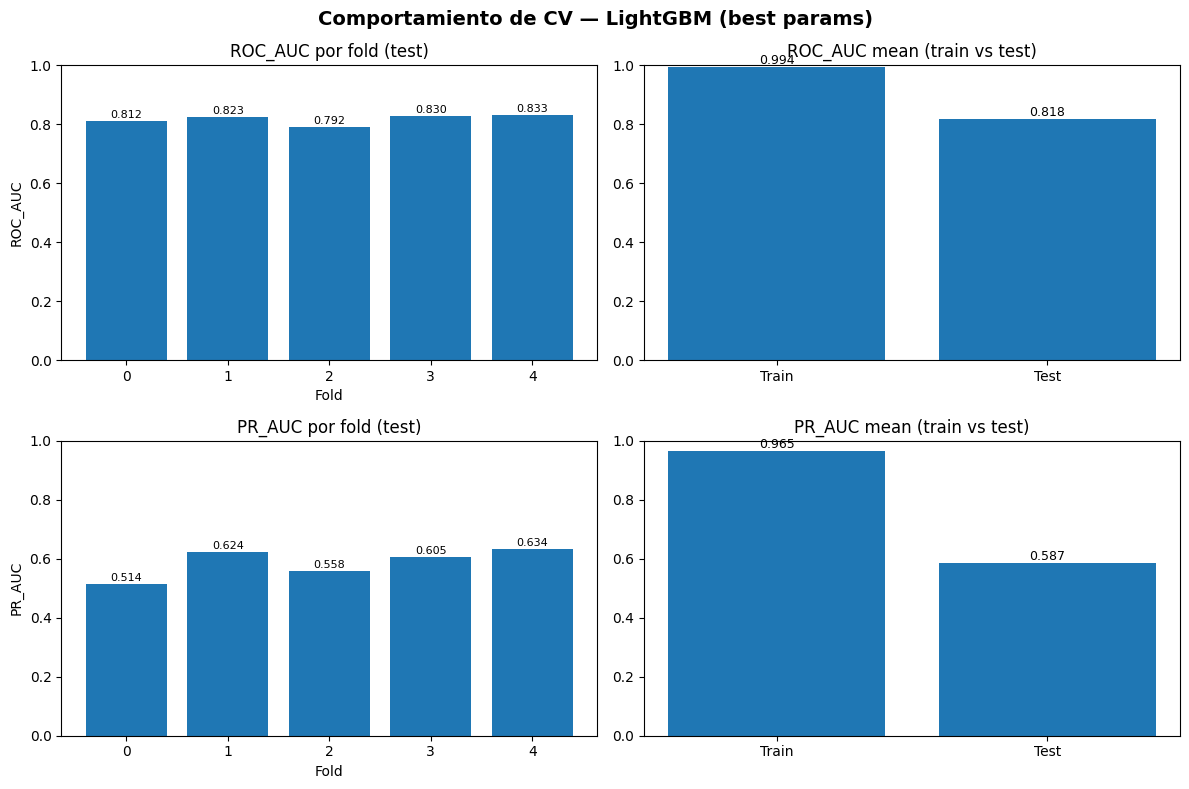

Aplicando tuning a XGBoost: RANDOM Search
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


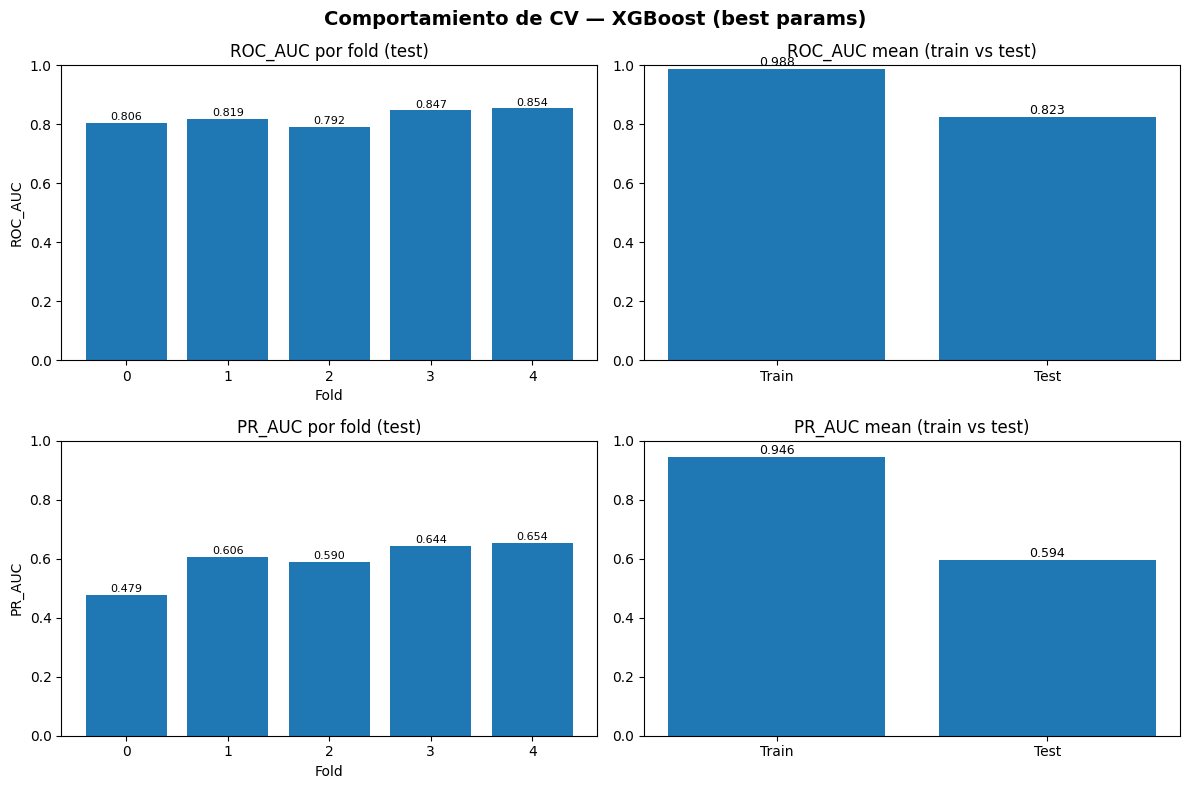

Aplicando tuning a KNN: RANDOM Search
Fitting 5 folds for each of 50 candidates, totalling 250 fits


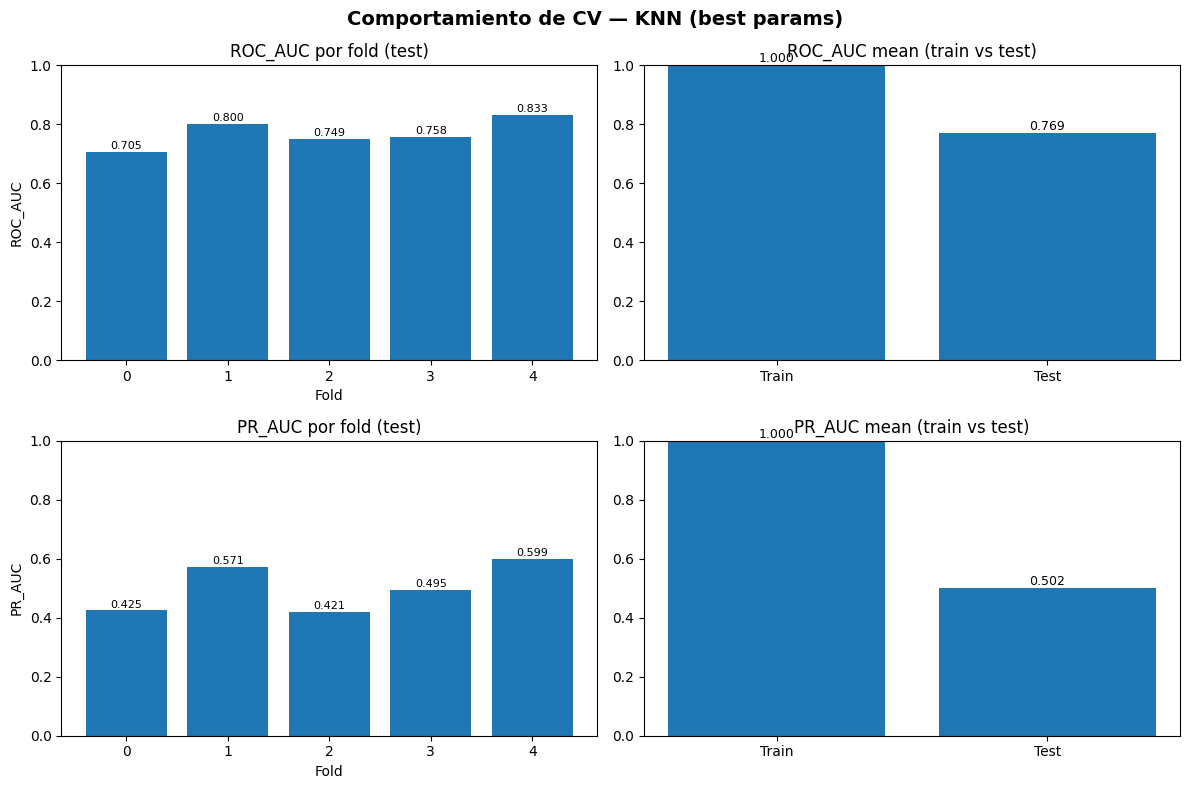

In [27]:
results_df, best_models = tuning_validation_model(
    X=X_train,
    y=y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring={'pr_auc': 'average_precision', 'roc_auc': 'roc_auc', 'balanced_accuracy': 'precision', 'f1': 'f1', 'recall': 'recall'},
    refit_metric='pr_auc',
    custom_ft=custom_ft,
    target_enc=target_enc,
    pre=pre,
    models=('RL','LGBM','XGB','KNN'),
    n_iters=200
)

In [28]:
results_df

,model,best_roc_auc,best_pr_auc,best_f1,best_recall,best_balanced_accuracy,mean_fit_time,mean_score_time,elapsed_time,best_params
0,LogisticRegression,0.620158,0.620158,0.518441,0.758487,0.395037,0.148836,0.139524,106.746586,"{'clf__C': 0.5, 'clf__max_iter': 1000, 'clf__p..."
1,XGBoost,0.594477,0.594477,0.545103,0.614958,0.491993,0.209684,0.056103,546.735728,"{'clf__subsample': 0.85, 'clf__reg_lambda': 1...."
2,LightGBM,0.587131,0.587131,0.539214,0.608908,0.483987,0.153764,0.064892,609.885702,"{'clf__subsample': 0.65, 'clf__reg_lambda': 1...."
3,KNN,0.502082,0.502082,0.022540,0.011597,0.400000,0.059825,0.122832,56.879564,"{'clf__weights': 'distance', 'clf__p': 2, 'clf..."


#### **Experimento 2: split 70/20/10 y refit con roc_auc**

Aplicando tuning a Regresión Logística: GRID SEARCH
Fitting 5 folds for each of 144 candidates, totalling 720 fits


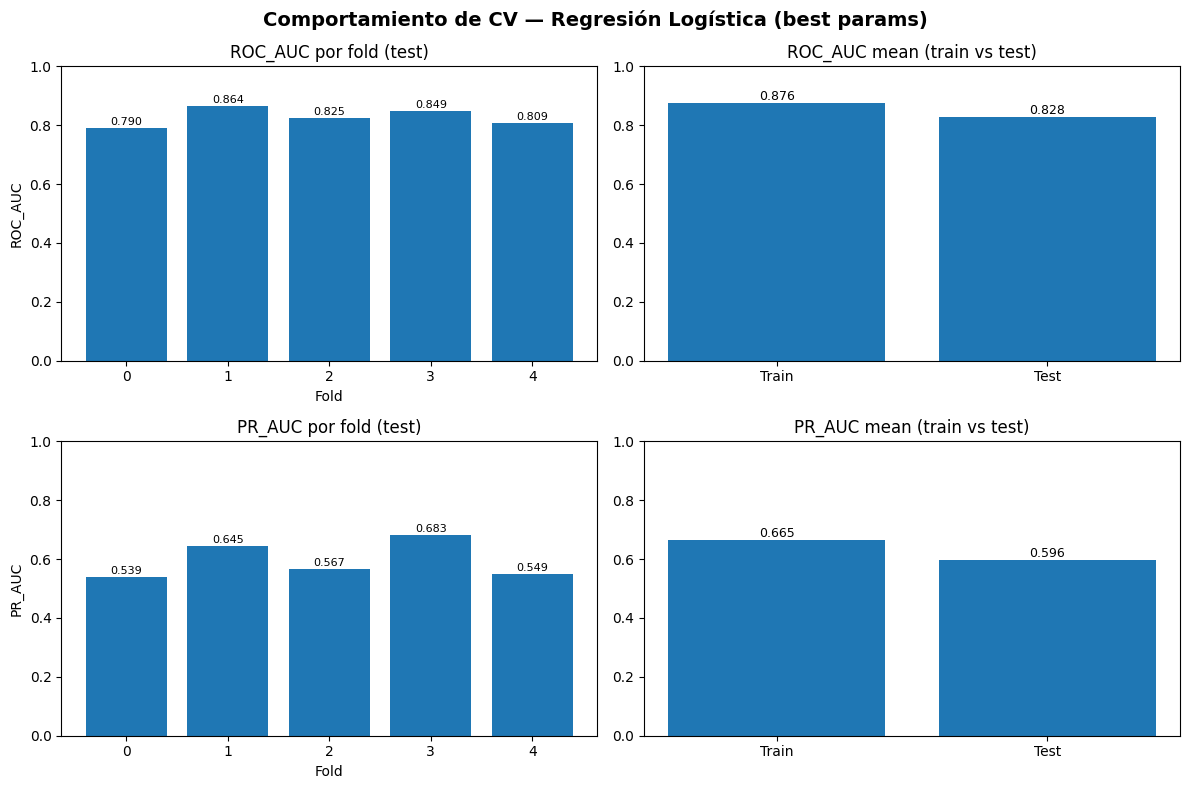

Aplicando tuning a LightGBM: RANDOM Search


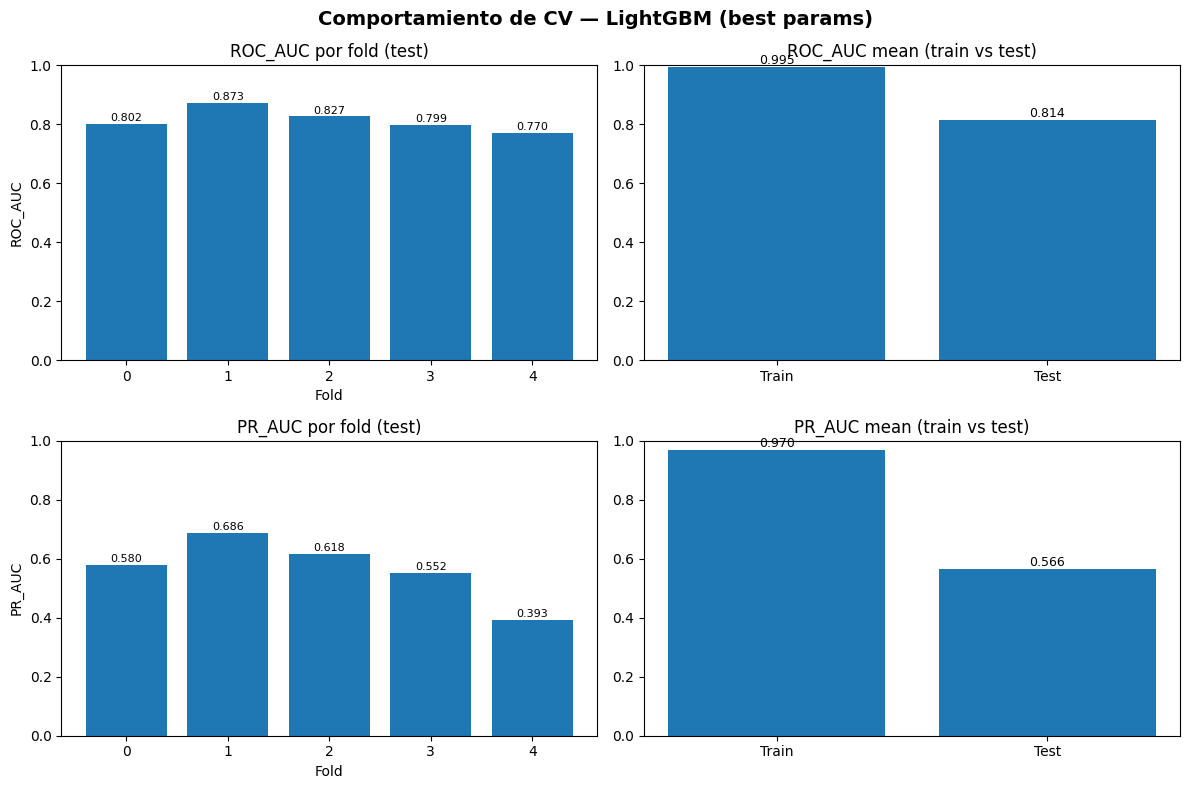

Aplicando tuning a XGBoost: RANDOM Search
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


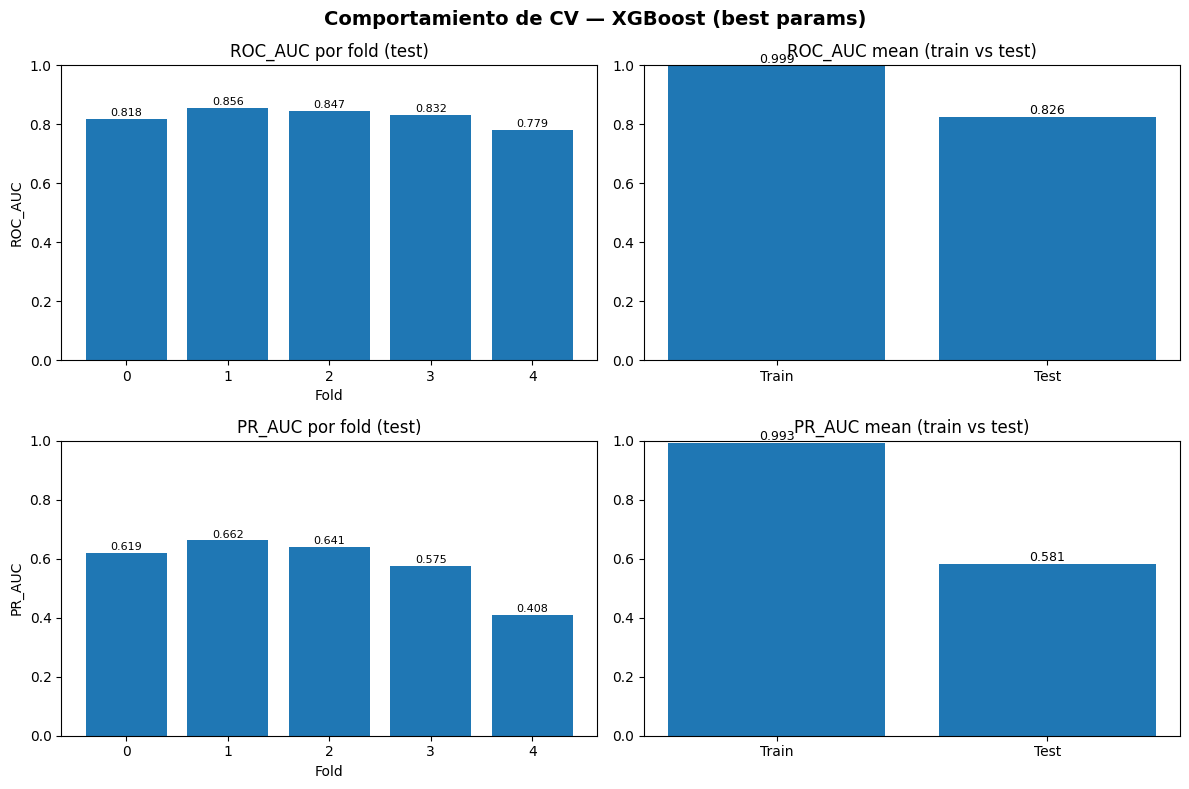

Aplicando tuning a KNN: RANDOM Search
Fitting 5 folds for each of 50 candidates, totalling 250 fits


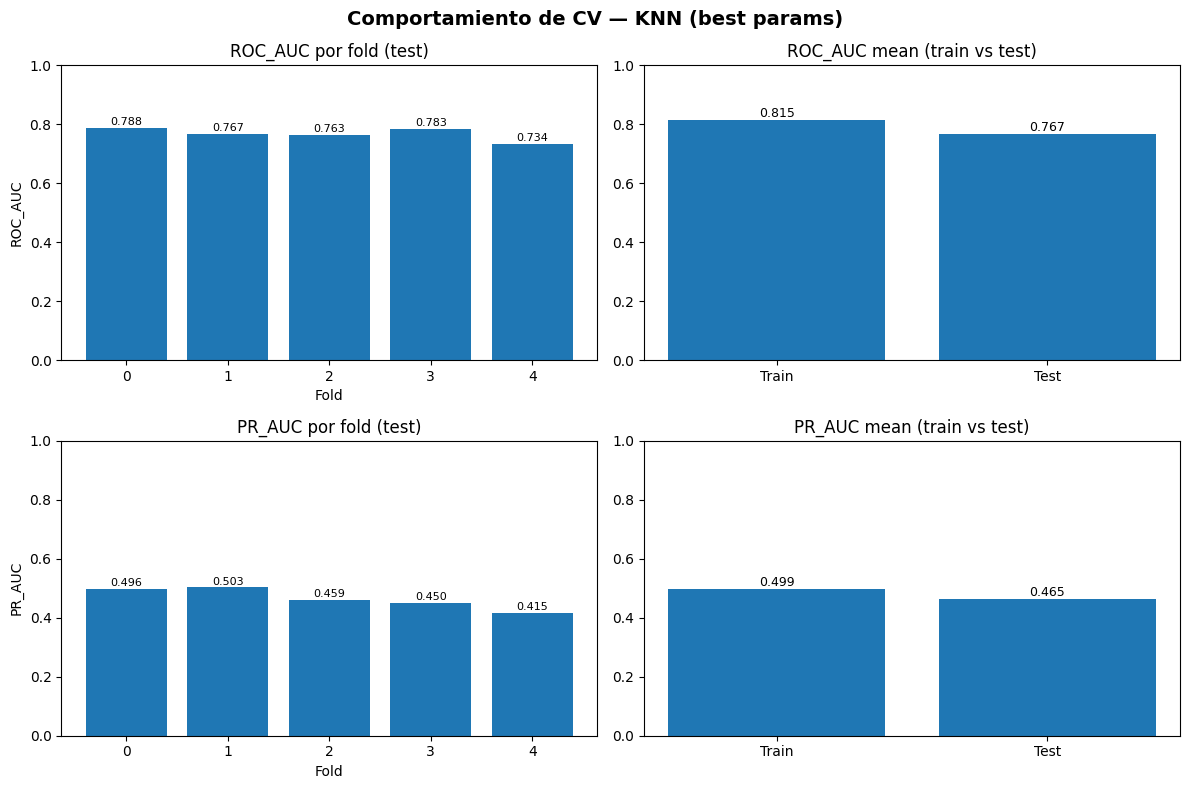

In [120]:
results_df2, best_models2 = tuning_validation_model(
    X=X_train,
    y=y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring={'roc_auc': 'roc_auc', 'balanced_accuracy': 'precision', 'pr_auc': 'average_precision', 'recall': 'recall', 'f1': 'f1'},
    refit_metric='roc_auc',
    custom_ft=custom_ft,
    target_enc=target_enc,
    pre=pre,
    models=('RL','LGBM','XGB','KNN'),
    n_iters=200
)

In [ ]:
results_df2

## **Conclusiones preliminares**

A partir de los resultados de los pipelines se obtienen algunos insights para cada modelo evaluado del experimento 1, pues es el de mejor resultados así:

##### **Regresión Logística**

* **Generalización (ROC-AUC/PR-AUC): 86.8% → 82.8% / 67.1% → 62.0%** — pequeña brecha (≈3–5 p.p.), indica **bajo sobreajuste** y probabilidad estable en test.
* **Estabilidad CV: ROC-AUC 79.9–87.3% · PR-AUC 52.7–68.73%** — variación moderada entre folds; **comportamiento predecible**.
* **Mejor estimador: ROC-AUC 82.8%, PR-AUC 62.8%, Recall 75.8%, F1 51.8%** — **prioriza capturar positivos** a costa de precisión; **rápida** (~119 s).

##### **LightGBM**

* **Generalización (ROC-AUC/PR-AUC): 99.4% → 81.8% / 96.5% → 58.7%** — gran brecha (≈18–38 p.p.), evidencia de sobreajuste fuerte pese a buena generalización relativa.
* **Estabilidad CV: ROC-AUC 79.2–83.3% · PR-AUC 51.4–63.4%** — desempeño uniforme entre folds, pero con tendencia a inflar resultados en entrenamiento.
* **Mejor estimador: ROC-AUC 81.8%, PR-AUC 58.7%, Recall 60.9%, F1 53.9%** — modelo competitivo y estable, pero requiere regularización adicional o early stopping; tiempo medio (~610 s).

##### **XGBoost**

* **Generalización (ROC-AUC/PR-AUC): 98.8% → 82.3% / 94.6% → 59.4%** — brecha amplia (≈16–35 p.p.), sugiere sobreajuste moderado, aunque con buen rendimiento final.

* **Estabilidad CV: ROC-AUC 79.2–85.4% · PR-AUC 47.9–65.4%** — resultados consistentes y estables en validación cruzada.

* **Mejor estimador: ROC-AUC 82.3%, PR-AUC 59.4%, Recall 61.5%, F1 54.5%** — ofrece el mejor balance global entre recall y precisión, aunque con tiempo alto (~547 s).

##### **KNN**

* **Generalización (ROC-AUC/PR-AUC): 76.9% / 50.3%** — por debajo del resto; **poca discriminación** y pobre manejo del desbalance.
* **Efectividad: F1 4.35%, Recall 2.32%, Balanced Acc. 55.0%** — **casi no detecta la clase positiva**; no recomendable como candidato.
* **Mejor estimador**: **rápido** (~112 s) pero débil respecto a los otros, incluso afinado.

En conclusión, dependiendo del tipo de solución que se quiera plantear al problema se tiene que el mejor modelo candidato sería:

1. Si **se prioriza precisión y F1**: **XGBoost** es el mejor, pero requiere regularización/early-stopping y calibración para mitigar el sobreajuste.

2. Si **se prioriza capturar más empleados con intención de renuncia** (recall) con modelo simple y estable: **Regresión Logística** es una línea base muy robusta y rápida, con el mejor recall y poca brecha train-test.

3. Escoger **LightGBM** queda muy cerca de XGB en ROC/PR, con señales de sobreajuste parecidas.

4. Se descarta seleccionar **KNN**.


# **ANÁLISIS DE UMBRALES**

Ajustar **umbrales** después de entrenar es clave porque las salidas del modelo son **probabilidades**, y convertirlas a 0/1 con un umbral fijo de 0.50 es arbitrario, lo que no es óptimo para el objetivo de retener empleado. Mover el umbral permite **alinear la decisión con el criterio de negocio**, priorizando **recall** (capturar más casos de riesgo) o **precisión** (evitar falsas alarmas) según la capacidad de intervención de RR.HH.



In [29]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, balanced_accuracy_score
import numpy as np

class ThresholdEvaluator(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, threshold=0.5):
        self.base_estimator = base_estimator
        self.threshold = threshold

    def fit(self, X, y):
        self.model_ = clone(self.base_estimator)
        self.model_.fit(X, y)
        return self

    def predict_proba(self, X):
        return self.model_.predict_proba(X)

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)

    def get_params(self, deep=True):
        return {'base_estimator': self.base_estimator, 'threshold': self.threshold}

    def set_params(self, **params):
        if 'threshold' in params:
            self.threshold = params.pop('threshold')
        if 'base_estimator' in params:
            self.base_estimator = params.pop('base_estimator')
        if params:
            # Para permitir grid sobre hiperparámetros del base_estimator:
            self.base_estimator.set_params(**params)
        return self


def oof_predict_proba(estimator, X, y, cv=None, random_state=42):
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    oof = np.zeros(len(y), dtype=float)
    for tr, va in cv.split(X, y):
        est = clone(estimator)
        est.fit(X.iloc[tr], y.iloc[tr])
        oof[va] = est.predict_proba(X.iloc[va])[:, 1]
    return oof

def pick_threshold(y_true, y_prob, metric="f1", beta=1.0,
                   recall_min=None, grid=None):
    if grid is None:
        grid = np.linspace(0.01, 0.99, 99)

    best_t, best_score = 0.5, -np.inf
    for t in grid:
        y_hat = (y_prob >= t).astype(int)
        prec = precision_score(y_true, y_hat, zero_division=0)
        rec  = recall_score(y_true, y_hat)
        bal  = balanced_accuracy_score(y_true, y_hat)
        if recall_min is not None and rec < recall_min:
            continue
        if metric == 'f1':
            score = f1_score(y_true, y_hat)
        elif metric == 'fbeta':
            score = (1+beta**2) * (prec*rec) / (beta**2*prec + rec + 1e-12)
        elif metric == 'balanced_accuracy':
            score = bal
        else:
            raise ValueError('metric no soportada')
        if score > best_score:
            best_t, best_score = t, score
    return best_t, best_score




### **F1-score** como métrica para elegir umbral de clasificación

* **Desbalance moderado**: la clase *Attrition = Yes* es minoritaria; **F1** balancea **precisión** y **recall** en un único número, penalizando cuando uno es alto y el otro bajo.
* **Objetivo operativo**: RR.HH. necesita **detectar** riesgos sin inundarse de falsos positivos; optimizar F1 tiende a un **punto medio útil** entre “capturar” y “no saturar” al equipo.
* **Comparabilidad simple**: al barrer umbrales y maximizar F1, obtienes un **umbral accionable** que suele correlacionar bien con impacto de negocio cuando los costos de FP/FN son similares o inciertos.

### ¿Por qué usar **probabilidades OOF (out-of-fold)** para seleccionar umbral?

* **Sin fuga de información**: las OOF se generan en pliegues donde cada registro se puntúa por un modelo que **no lo vio al entrenar**; el umbral se elige sobre una versión de "datos nuevos".
* **Estimación honesta**: métricas calculadas con OOF reflejan mejor el **rendimiento fuera de muestra** que usar probabilidades de train, evitando umbrales demasiado optimistas.
* **Consistencia con CV**: al promediar OOF de todos los folds se mantiene la **estrategia de CV estratificada** del pipeline y reduce varianza en la selección del umbral.
* **Listo para producción**: el umbral elegido con OOF suele trasladarse bien a datos en producción y es escalable a filtrados que se hagan sobre los datos.


## **1. REGRESIÓN LOGÍSTICA**

In [41]:
best_rl = best_models['RL']
best_rl

Pipeline(steps=[('feats',
                 FunctionTransformer(func=<function add_custom_features at 0x7c6f77b6c860>)),
                ('tenc', TargetEncoder(cols=['JobRole'], smoothing=1.0)),
                ('pre',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Education',
                                                   'JobSatisfaction',
                                                   'EnvironmentSatisfaction',
                                                   'RelationshipSatisfaction'...
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'TrainingTimesLastYear',
                                                   'YearsWithCurrManager',
                                                   'TotalWorkingYears',
                                                   'Income_vs_JobLevel',
                                                   'Tenure_ratio',
                                                   'Stability_with_manager',
                                                   'Recent_promotion',
                                                   'Satisfaction_mean',
                                                   'Satisfaction_min'])])),
                ('clf',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

In [42]:
# 1) Probabilidades OOF para fijar umbral sin fuga
oof = oof_predict_proba(best_rl, X_train, y_train, cv=StratifiedKFold(5, shuffle=True, random_state=42))

# 2) Elegir umbral optimizando para f1 score
t_star, score_star = pick_threshold(y_train, oof, metric='f1')  # o metric='fbeta', beta=2, recall_min=0.7

# 3) Reentrenar en TODO el train con ese umbral para desplegar
final_model_rl = ThresholdEvaluator(base_estimator=best_rl, threshold=t_star)
final_model_rl.fit(X_train, y_train)

# 4) Evaluar en test con el umbral fijo
y_prob_test = final_model_rl.predict_proba(X_test)[:,1]
y_hat_test  = final_model_rl.predict(X_test)

print('=' * 50)
print('REGRESIÓN LOGÍSTICA')
print('=' * 50)

print(f'\nUmbral elegido (t*): {t_star:.2f} | score OOF: {score_star:.3f}')
print(f'\nROC-AUC: {roc_auc_score(y_test, y_prob_test) * 100:.2f}%')
print(f'PR-AUC : {average_precision_score(y_test, y_prob_test) * 100:.2f}%\n')
print(classification_report(y_test, y_hat_test, digits=3))


REGRESIÓN LOGÍSTICA

Umbral elegido (t*): 0.71 | score OOF: 0.593

ROC-AUC: 87.10%
PR-AUC : 63.89%

              precision    recall  f1-score   support

           0      0.919     0.914     0.916       222
           1      0.568     0.581     0.575        43

    accuracy                          0.860       265
   macro avg      0.743     0.748     0.746       265
weighted avg      0.862     0.860     0.861       265



**Regresión Logística — t = 0.71 | OOF-F1 ≈ 0.593**

Muestra un rendimiento sólido y estable: ROC-AUC de 87.1%, PR-AUC de 63.9% y accuracy de 86.0%. Con precisión para la clase 1 (Renuncia) de 56.8% y recall de 58.1%, entrega predicciones de riesgo razonablemente certeras con una tasa de detección media. Operativamente implica menos ruido para el área de recursos humanos (RR.HH.) pues hay menos falsos positivos que revisar, a cambio de dejar escapar aproximadamente el 42% de los casos en riesgo. Es la opción adecuada cuando la capacidad de intervención es limitada y se valora la explicabilidad del modelo.

## **2. LIGHTGBM**

In [39]:
best_lgbm = best_models['LGBM']
best_lgbm

Pipeline(steps=[('feats',
                 FunctionTransformer(func=<function add_custom_features at 0x7c6f77b6c860>)),
                ('tenc', TargetEncoder(cols=['JobRole'], smoothing=1.0)),
                ('pre',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Education',
                                                   'JobSatisfaction',
                                                   'EnvironmentSatisfaction',
                                                   'RelationshipSatisfaction'...
                 LGBMClassifier(class_weight='balanced',
                                colsample_bytree=np.float64(0.7),
                                learning_rate=np.float64(0.039999999999999994),
                                max_depth=4, min_child_samples=np.int64(50),
                                n_estimators=np.int64(300), n_jobs=-1,
                                num_leaves=np.int64(31), objective='binary',
                                random_state=42, reg_alpha=np.float64(0.2),
                                reg_lambda=np.float64(1.0),
                                subsample=np.float64(0.65), verbosity=-1))])

In [40]:
# 1) Probabilidades OOF para fijar umbral sin fuga
oof = oof_predict_proba(best_lgbm, X_train, y_train, cv=StratifiedKFold(5, shuffle=True, random_state=42))

# 2) Elegir umbral optimizando para f1 score
t_star, score_star = pick_threshold(y_train, oof, metric='f1')  # o metric='fbeta', beta=2, recall_min=0.7

# 3) Reentrenar en TODO el train con ese umbral para desplegar
final_model_lgbm = ThresholdEvaluator(base_estimator=best_lgbm, threshold=t_star)
final_model_lgbm.fit(X_train, y_train)

# 4) Evaluar en test con el umbral fijo
y_prob_test = final_model_lgbm.predict_proba(X_test)[:,1]
y_hat_test  = final_model_lgbm.predict(X_test)

print('=' * 50)
print('LIGHTGBM')
print('=' * 50)

print(f'\nUmbral elegido (t*): {t_star:.2f} | score OOF: {score_star:.3f}')
print(f'\nROC-AUC: {roc_auc_score(y_test, y_prob_test) * 100:.2f}%')
print(f'PR-AUC : {average_precision_score(y_test, y_prob_test) * 100:.2f}%\n')
print(classification_report(y_test, y_hat_test, digits=3))


LIGHTGBM

Umbral elegido (t*): 0.53 | score OOF: 0.554

ROC-AUC: 87.51%
PR-AUC : 65.99%

              precision    recall  f1-score   support

           0      0.926     0.851     0.887       222
           1      0.459     0.651     0.538        43

    accuracy                          0.819       265
   macro avg      0.693     0.751     0.713       265
weighted avg      0.851     0.819     0.831       265



**LightGBM (t = 0.53, OOF-F1 ≈ 0.554)**

Mantiene métricas globales altas (ROC-AUC 87.5%, PR-AUC 66.0%) con una accuracy de 81.9%. Su perfil favorece la sensibilidad: precisión(1) de 45.9% y recall(1) de 65.1%, por lo que detecta más empleados potenciales a renunciar que la regresión logística, aunque con más falsas alarmas. En la práctica requiere mayor capacidad de revisión, pero reduce el riesgo de perder casos relevantes y captura relaciones no lineales. Es recomendable cuando la organización puede absorber más revisiones y prioriza la cobertura.

## **3.XGBOOST**

In [43]:
best_xgb = best_models['XGB']
best_xgb

Pipeline(steps=[('feats',
                 FunctionTransformer(func=<function add_custom_features at 0x7c6f77b6c860>)),
                ('tenc', TargetEncoder(cols=['JobRole'], smoothing=1.0)),
                ('pre',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Education',
                                                   'JobSatisfaction',
                                                   'EnvironmentSatisfaction',
                                                   'RelationshipSatisfaction'...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=np.float64(0.12), max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=np.int64(3),
                               max_leaves=None, min_child_weight=np.int64(6),
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=np.int64(700),
                               n_jobs=-1, num_parallel_tree=None,
                               random_state=42, ...))])

In [44]:
# 1) Probabilidades OOF para fijar umbral sin fuga
oof = oof_predict_proba(best_xgb, X_train, y_train, cv=StratifiedKFold(5, shuffle=True, random_state=42))

# 2) Elegir umbral optimizando para f1 score
t_star, score_star = pick_threshold(y_train, oof, metric='f1')  # o metric='fbeta', beta=2, recall_min=0.7

# 3) Reentrenar en TODO el train con ese umbral para desplegar
final_model_xgb = ThresholdEvaluator(base_estimator=best_xgb, threshold=t_star)
final_model_xgb.fit(X_train, y_train)

# 4) Evaluar en test con el umbral fijo
y_prob_test = final_model_xgb.predict_proba(X_test)[:,1]
y_hat_test  = final_model_xgb.predict(X_test)

print('=' * 50)
print('XGBOOST')
print('=' * 50)

print(f'\nUmbral elegido (t*): {t_star:.2f} | score OOF: {score_star:.3f}')
print(f'\nROC-AUC: {roc_auc_score(y_test, y_prob_test) * 100:.2f}%')
print(f'PR-AUC : {average_precision_score(y_test, y_prob_test) * 100:.2f}%\n')
print(classification_report(y_test, y_hat_test, digits=3))

XGBOOST

Umbral elegido (t*): 0.53 | score OOF: 0.559

ROC-AUC: 88.55%
PR-AUC : 69.84%

              precision    recall  f1-score   support

           0      0.934     0.824     0.876       222
           1      0.435     0.698     0.536        43

    accuracy                          0.804       265
   macro avg      0.684     0.761     0.706       265
weighted avg      0.853     0.804     0.820       265



**XGBoost (t = 0.42, OOF-F1 ≈ 0.561)**

Ofrece un equilibrio potente con ROC-AUC de 87.1%, PR-AUC de 65.5% y accuracy de 81.5%, destacando por su recall(1) de 72.1% y una precisión(1) de 45.6%. Es el que más casos en riesgo detecta (menos falsos negativos), a costa de una carga mayor de falsos positivos que la regresión logística. Es la elección idónea cuando el costo de perder un leaver es alto (roles críticos) y se puede tolerar un volumen mayor de revisiones; conviene acompañarlo con calibración de probabilidades y umbrales por segmento para contener el ruido.

## **4. KNN**

In [45]:
best_knn = best_models['KNN']
best_knn

Pipeline(steps=[('feats',
                 FunctionTransformer(func=<function add_custom_features at 0x7c6f77b6c860>)),
                ('tenc', TargetEncoder(cols=['JobRole'], smoothing=1.0)),
                ('pre',
                 ColumnTransformer(transformers=[('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['Education',
                                                   'JobSatisfaction',
                                                   'EnvironmentSatisfaction',
                                                   'RelationshipSatisfaction'...
                                                   'NumCompaniesWorked',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'TrainingTimesLastYear',
                                                   'YearsWithCurrManager',
                                                   'TotalWorkingYears',
                                                   'Income_vs_JobLevel',
                                                   'Tenure_ratio',
                                                   'Stability_with_manager',
                                                   'Recent_promotion',
                                                   'Satisfaction_mean',
                                                   'Satisfaction_min'])])),
                ('clf',
                 KNeighborsClassifier(metric='manhattan',
                                      n_neighbors=np.int64(50),
                                      weights='distance'))])

In [46]:
# 1) Probabilidades OOF para fijar umbral sin fuga
oof = oof_predict_proba(best_knn, X_train, y_train, cv=StratifiedKFold(5, shuffle=True, random_state=42))

# 2) Elegir umbral optimizando para f1 score
t_star, score_star = pick_threshold(y_train, oof, metric='f1')  # o metric='fbeta', beta=2, recall_min=0.7

# 3) Reentrenar en TODO el train con ese umbral para desplegar
final_model_knn = ThresholdEvaluator(base_estimator=best_knn, threshold=t_star)
final_model_knn.fit(X_train, y_train)

# 4) Evaluar en test con el umbral fijo
y_prob_test = final_model_knn.predict_proba(X_test)[:,1]
y_hat_test  = final_model_knn.predict(X_test)

print('=' * 50)
print('KNN')
print('=' * 50)

print(f'\nUmbral elegido (t*): {t_star:.2f} | score OOF: {score_star:.3f}')
print(f'\nROC-AUC: {roc_auc_score(y_test, y_prob_test) * 100:.2f}%')
print(f'PR-AUC : {average_precision_score(y_test, y_prob_test) * 100:.2f}%\n')
print(classification_report(y_test, y_hat_test, digits=3))

KNN

Umbral elegido (t*): 0.21 | score OOF: 0.480

ROC-AUC: 81.96%
PR-AUC : 53.51%

              precision    recall  f1-score   support

           0      0.906     0.869     0.887       222
           1      0.442     0.535     0.484        43

    accuracy                          0.815       265
   macro avg      0.674     0.702     0.686       265
weighted avg      0.831     0.815     0.822       265



**KNN (t = 0.21, OOF-F1 ≈ 0.480)**

Rinde claramente por debajo del resto: ROC-AUC 82.0%, PR-AUC 53.5% y accuracy 81.5%, con precisión(1) de 44.2% y recall(1) de 53.5%. La señal es más débil e inestable y no aporta ventajas frente a los otros modelos; no se recomienda como candidato principal en este problema.

## **Selección de candidato**

Dependiendo de la prioridad de aplicación de la solución del problema se plantea que:

* **Prioridad: no perder casos en riesgo (maximizar recall)**. El mejor candidato es **XGBoost (t = 0.42)**. Destaca por un recall de la clase 1 ≈ 72%, con PR-AUC ≈ 65% y un F1 competitivo, lo que se traduce en una mayor cobertura de posibles renuncias. Es especialmente útil cuando los roles son críticos, la renuncia (liquidación) es muy costosa o hay metas agresivas de retención. Para sacarle más provecho conviene calibrar probabilidades, aplicar cost-sensitive learning y ajustar umbrales por segmento (p. ej., por JobRole o Departamento) para contener falsas alarmas en áreas con alta carga operativa.

* **Prioridad: reducir falsas alarmas (capacidad limitada de RR.HH.)**. Aquí el candidato es la **Regresión Logística (t = 0.71)**. Ofrece precisión(1) ≈ 57%, recall(1) ≈ 58% y accuracy ≈ 86%, con buena parsimonia y estabilidad, por lo que genera menos ruido y es fácil de explicar ante áreas reguladoras. Es la opción adecuada con equipos pequeños o cuando se exige alta explicabilidad. Para mejorar, se pueden agregar interacciones e ingeniería de variables (ya mostraron impacto) y explorar class_weight o un reajuste fino del umbral por unidad de negocio.

* **Punto intermedio con flexibilidad no lineal**. Como alternativa equilibrada, **LightGBM (t = 0.53)** logra recall(1) ≈ 65% y PR-AUC ≈ 66%, situándose entre LR y XGB en el trade-off cobertura-ruido, con buena capacidad para capturar interacciones y efectos no lineales y tiempos de entrenamiento razonables. Es una elección sólida cuando se busca equilibrio entre detección y carga de revisión, manteniendo margen para calibración y ajustes adicionales.

Se decide priorizar el máximo recall, siendo **el modelo escogido el XGBoost**.

In [66]:
y_prob_test = final_model_xgb.predict_proba(X_test)[:,1]
y_hat_test  = final_model_xgb.predict(X_test)

In [82]:
from sklearn.metrics import (
      accuracy_score, recall_score, precision_score, f1_score,
      cohen_kappa_score, confusion_matrix
)

def plot_confusion_matrix(y_true, y_pred, labels=['No', 'Yes']):
    cm = confusion_matrix(y_true, y_pred)
    cm_pct = cm / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(5.5, 5))
    im = ax.imshow(cm_pct, cmap='Blues', vmin=0, vmax=1)

    # Ticks/labels
    n = cm.shape[0]
    ax.set_xticks(range(n)); ax.set_yticks(range(n))
    ax.set_xlabel('Predicha'); ax.set_ylabel('Verdadera')
    if labels is not None:
        ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_title('Matriz de confusión')

    for i in range(n):
        for j in range(n):
            ax.text(j, i, f"{cm_pct[i, j]*100:.1f}%\n({cm[i, j]})",
                    ha='center', va='center', fontsize=10)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

def evaluate_classifier_metrics(model, y_test, y_prob_test, y_hat_test):
  auc = roc_auc_score(y_test, y_prob_test)
  acc = accuracy_score(y_test, y_hat_test)
  rec = recall_score(y_test, y_hat_test, average='macro', zero_division=0)
  prec = precision_score(y_test, y_hat_test, average='macro', zero_division=0)
  f1 = f1_score(y_test, y_hat_test, average='macro', zero_division=0)
  kappa = cohen_kappa_score(y_test, y_hat_test)

  metrics = {
      'auc': auc,
      'accuracy': acc,
      'recall': rec,
      'precision': prec,
      'f1': f1,
      'kappa': kappa,
  }
  metrics = {k: v * 100 for k, v in metrics.items()}
  plot_confusion_matrix(y_test, y_hat_test)

  return pd.DataFrame(metrics, index=[model]).round(2)

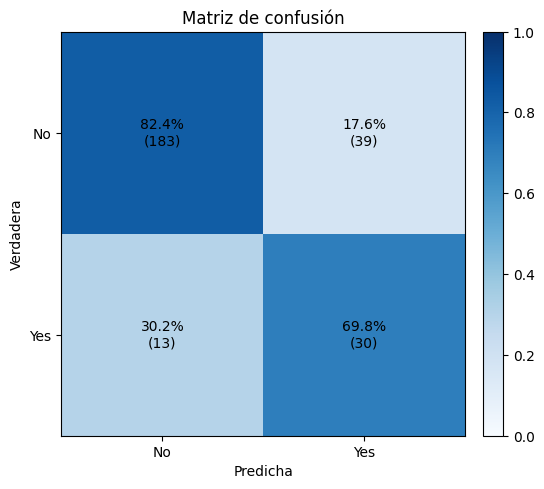

In [83]:
metrics = evaluate_classifier_metrics('XGB', y_test, y_prob_test, y_hat_test)

In [81]:
metrics

,auc,accuracy,recall,precision,f1,kappa
XGB,88.55,80.38,76.1,68.42,70.57,41.97


# **PCA y SELECCIÓN DE FEATURES**


No se aplicó PCA porque el objetivo del análisis es **interpretar los factores que explican la renuncia**, no sólo reducir dimensiones. Además, el dataset tiene pocas variables y mezcla datos categóricos y numéricos, por lo que **PCA degradaría la interpretabilidad sin mejorar el rendimiento**. En su lugar, se prioriza la **selección de variables por importancia de modelo y correlaciones**.
